In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from numpy import polyval
from joblib import Parallel, delayed

import time

In [2]:
def flatten_and_mask_shots(shots, mask,):
    num_shots = shots.shape[0]
    size = shots.shape[1]*shots.shape[2]
    flat_mask = mask.reshape(size)
    flat_shots =  shots.reshape( (num_shots,size))*flat_mask
    
    return flat_shots[:,flat_mask]

def unflatten_shots(flat_shots,mask):
    num_shots = flat_shots.shape[0]
    shape = mask.shape
    flat_mask = mask.reshape(shape[0]*shape[1]
                            )
    shots = np.zeros( (num_shots,shape[0]*shape[1]), dtype = flat_shots.dtype)
    shots[:, flat_mask ] = flat_shots
    
    return shots.reshape( (num_shots,shape[0],shape[1]))

In [3]:
run = 71
f = h5py.File('/reg/d/psdm/cxi/cxilr6716/results/\
flatfield_calibration/ave_int_statisitcs/run%d_ave_int.h5'%run,'r')
# f.keys()

f_mask = h5py.File('/reg/d/psdm/cxi/cxilr6716/results/masks/run%d_masks.h5'%run,'r')
mask=f_mask['mask'].value

f_cali = h5py.File('/reg/d/psdm/cxi/cxilr6716/results/\
flatfield_calibration/calibration_curves/run%d.tbl'%run,'r')
coefs = f_cali['poly_coefs'].value
ref_ind = f_cali['ref_shot_ind'].value

num_shots=f_cali['num_shots_per_bin'].value
flat_ave_shots = f['ave_flat_shots'].value
num_shots = f['num_shots_per_bin'].value

# thresholding
select=num_shots>10
flat_ave_shots = flat_ave_shots[select]
flat_std_shots = f['ave_flat_shots_err'].value[select]

ave_bin_int = f_cali['ave_bin_int'].value
print flat_ave_shots.shape,ave_bin_int.shape,coefs.shape

(22, 2223908) (22,) (2223908, 11)


In [4]:
print coefs.shape
ref_shot = flat_ave_shots[ref_ind]/flat_ave_shots[ref_ind].mean()
test_ind =18
intensity=flat_ave_shots[test_ind].mean()
test_shot = flat_ave_shots[test_ind]/intensity
diff = test_shot/(ref_shot)-1
diff_img = unflatten_shots(diff[None,:],mask)[0]

ref_int = flat_ave_shots[ref_ind].mean()

(2223908, 11)


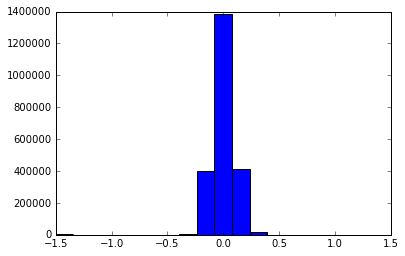

In [5]:
_=plt.hist(diff,bins=np.linspace(-1.5,1.5,20))

-82.5270342107 32.2555769655 0.0718689446156


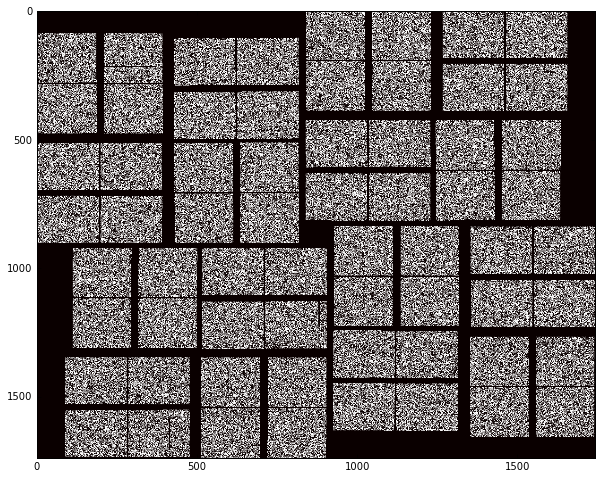

In [12]:
print diff.min(),diff.max(),np.abs(diff).mean()
plt.figure(figsize=[10,8])
plt.imshow((diff_img*mask)>-0.,aspect='auto',vmin=0,vmax=1, cmap = 'hot')
# plt.colorbar()


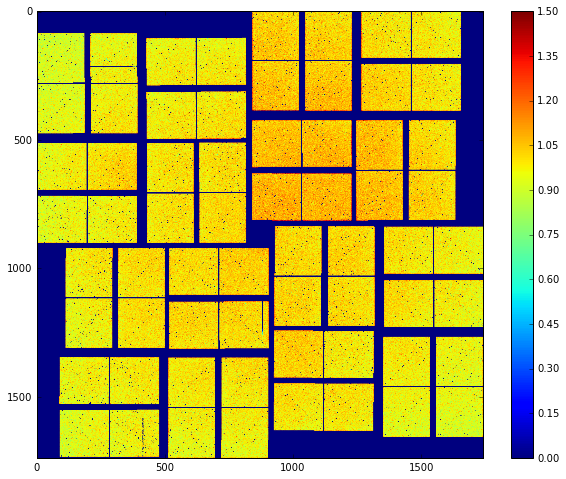

In [12]:
plt.figure(figsize=[10,8])
plt.imshow(unflatten_shots(ref_shot[None,:],mask)[0],aspect='auto',vmin=0,vmax=1.5)
plt.colorbar()

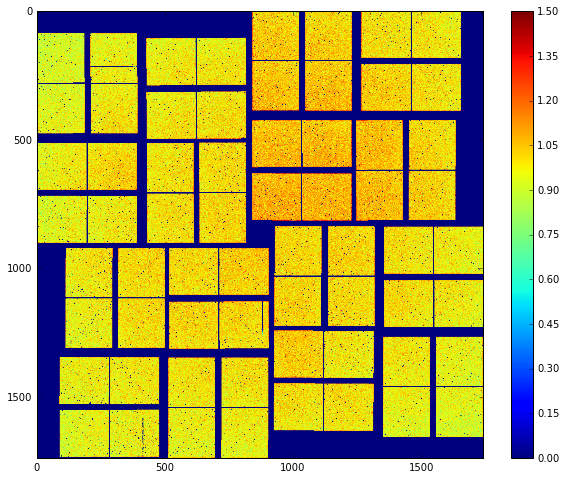

In [13]:
plt.figure(figsize=[10,8])
plt.imshow(unflatten_shots(test_shot[None,:],mask)[0],aspect='auto',vmin=0,vmax=1.5)
plt.colorbar()

In [14]:
tic = time.time()

x = np.array([ (intensity-ref_int)**ii for ii in range(coefs.shape[-1])[::-1]])
calibrated_shot = coefs.dot(x[:,None]).T
time.time()-tic
print calibrated_shot.shape

calibrated_shot.std(),flat_ave_shots[test_ind].std()
calibrated_shot/=calibrated_shot.mean(-1)

(1, 2223908)


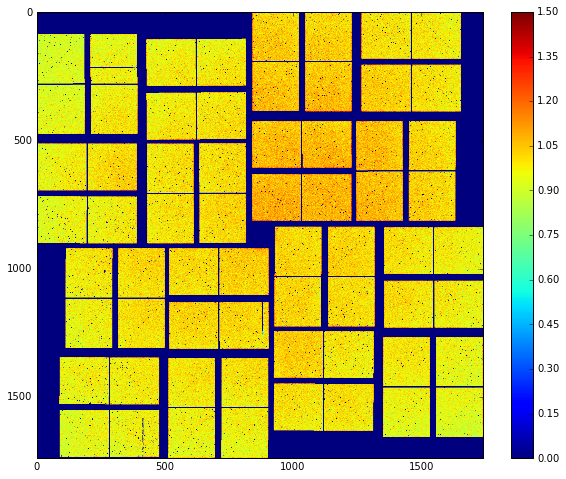

In [15]:
plt.figure(figsize=[10,8])
plt.imshow(unflatten_shots(calibrated_shot,mask)[0], vmin=0,vmax =1.5)
plt.colorbar()

In [16]:
cali_diff = calibrated_shot[0]/ ref_shot -1

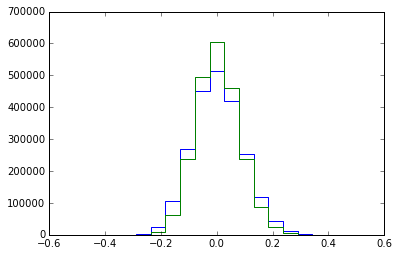

In [17]:
hist1=np.histogram(diff,bins=np.linspace(-0.5,0.5,20))
hist2=np.histogram(cali_diff,bins=np.linspace(-0.5,0.5,20))

plt.step(hist1[1][1:],hist1[0])

plt.step(hist2[1][1:],hist2[0])

In [21]:
intensity_x = np.array([[(int-ref_int)**ii for ii in range(coefs.shape[-1])[::-1]] for int in ave_bin_int])
cali_cuvres = np.array([coefs.dot(xx[:,None])[:,0] for xx in intensity_x])

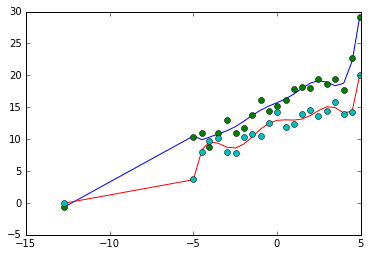

In [25]:
for idx in [10,100000]:
    plt.plot(ave_bin_int-ref_int,cali_cuvres[:,idx])
    plt.plot(ave_bin_int-ref_int,flat_ave_shots[:,idx],'o')
# plt.xlim(7,18)

In [26]:
universal_gain = 1./ref_shot
universal_gain[ref_shot<0]=0

In [27]:
# first derivative of the calibration curves
derivative_x = np.array([[ii*(int-ref_int)**(ii-1) for ii in range(1,coefs.shape[-1])[::-1]] for int in ave_bin_int])
cali_derivative = np.array([coefs[:,:-1].dot(xx[:,None])[:,0] for xx in derivative_x])

In [28]:
cali_derivative.shape

(22, 2223908)

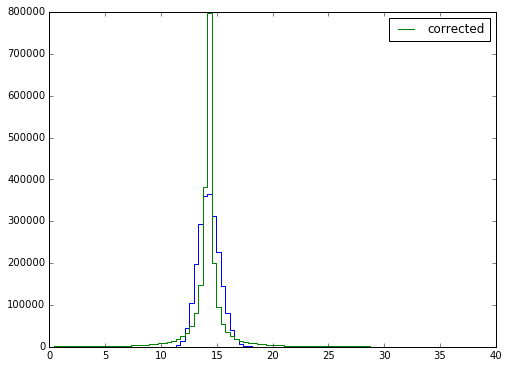

In [36]:
test_ind= 14
ref_derivative = cali_derivative[ref_ind]
test_derivative = cali_derivative[test_ind]

correction = ref_derivative/test_derivative \
* universal_gain *( flat_ave_shots[test_ind] - cali_cuvres[test_ind])
corrected_test_int=ave_bin_int[test_ind] + correction
test_int = universal_gain * flat_ave_shots[test_ind]

bins = np.linspace(0,40,100)
hist1=np.histogram(test_int,bins=bins)
# bins = np.linspace(5,30,100)
hist2=np.histogram(corrected_test_int,bins=bins)

plt.figure(figsize=[8,6])


plt.step(hist1[1][1:],hist1[0])

plt.step(hist2[1][1:],hist2[0], label='corrected')
plt.legend()

553.002433091 1.06919571297
13.7277683799 14.278091115


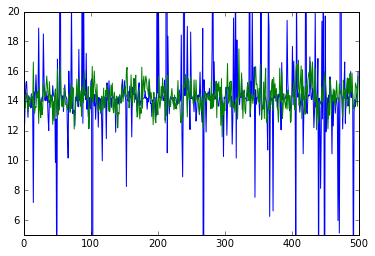

In [37]:
plt.plot(corrected_test_int[23456:23956])
plt.plot(test_int[23456:23956])
# plt.plot(correction[23456:23956])
plt.ylim(5,20)
print corrected_test_int.std(), test_int.std()
print corrected_test_int.mean(), test_int.mean()

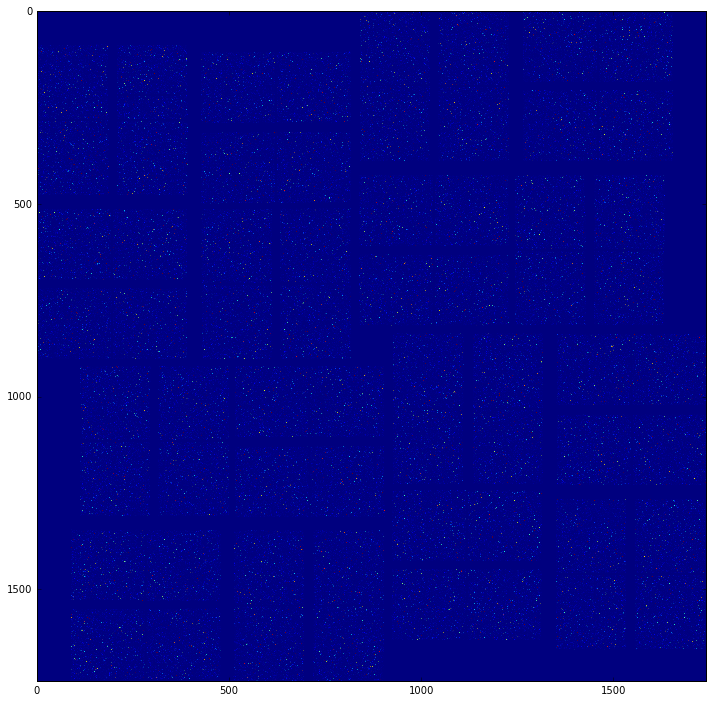

In [38]:
plt.figure(figsize=[12,12])

# plt.imshow(unflatten_shots(test_int[None,:], mask)[0], aspect = 'auto', 
#           vmin=10,vmax = 20)

plt.imshow(unflatten_shots(corrected_test_int[None,:], mask)[0], aspect = 'auto', 
          vmin=14,vmax = 100)

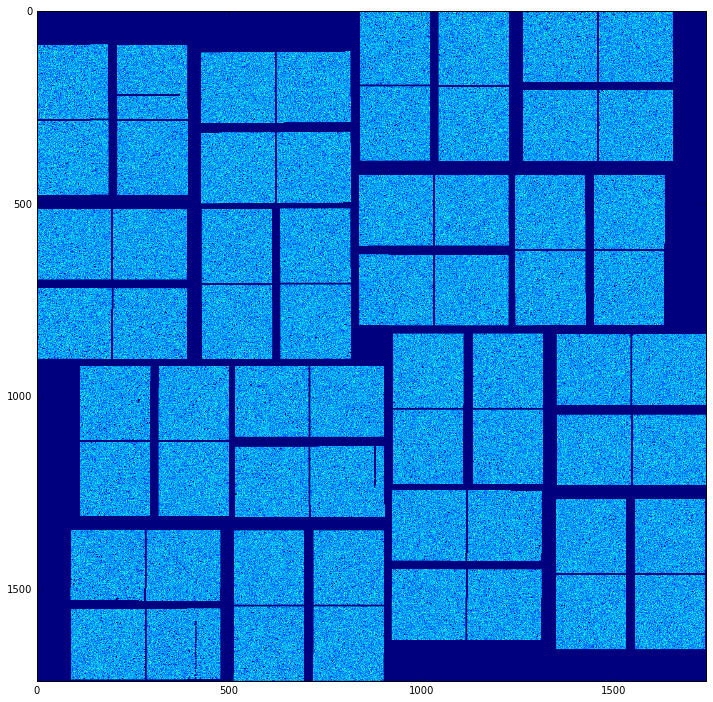

In [39]:
plt.figure(figsize=[12,12])

plt.imshow(unflatten_shots(test_int[None,:], mask)[0], aspect = 'auto', 
          vmin=10,vmax = 25)

In [54]:
# let's try to correct a single shot, not an average shot
f_shots = h5py.File('/reg/d/psdm/cxi/cxilr6716/scratch/flatfield_calibration/flat_det_imgs/fullImgs_run%d.h5'%run,'r')
print f_shots.keys()
single_shot = f_shots['flat_img'][1000]
single_shot_int = single_shot.mean()-ref_int
print single_shot_int
single_shot_photon = single_shot*universal_gain

[u'ave_tot_int', u'ebeam', u'event_time', u'evr', u'fiducials', u'flat_img', u'gas_detector', u'phase_cav']
1.32654781689


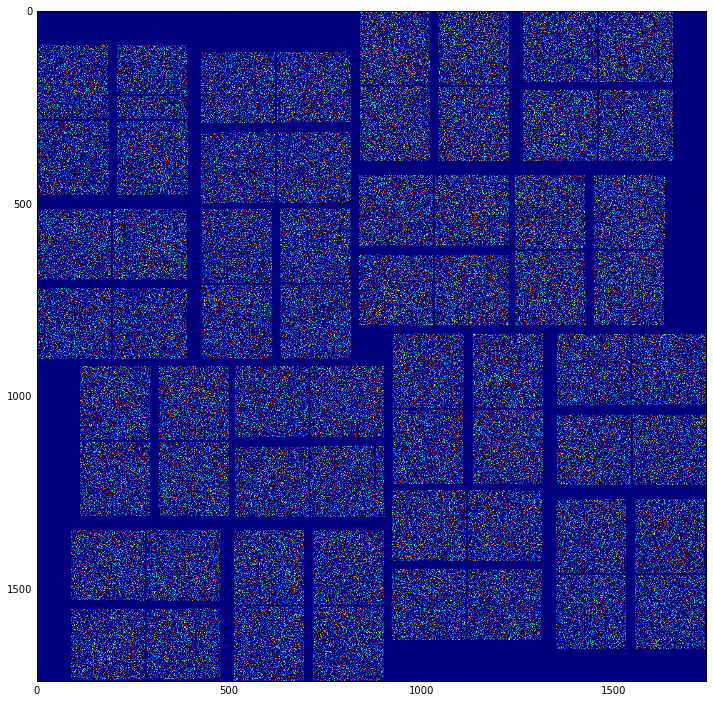

In [55]:
plt.figure(figsize=[12,12])

plt.imshow(unflatten_shots(single_shot[None,:], mask)[0], aspect = 'auto'
,vmin=20,vmax = 40)
# plt.colorbar()

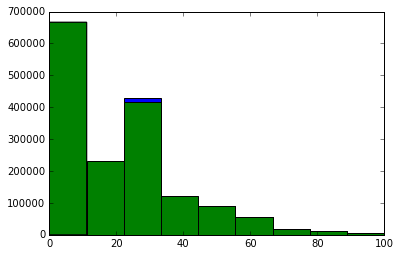

In [56]:
_=plt.hist(single_shot,bins = np.linspace(0,100,10))
_=plt.hist(single_shot_photon,bins = np.linspace(0,100,10))

In [57]:
def calibrate_to_flat_int(ref_derivative, universal_gain,
                          cali_cuvres,
                          coefs, intensity,
                         dn):
    derivative_x = np.array([ii*intensity**(ii-1) for ii in range(1,coefs.shape[-1])[::-1]])
    cali_derivative = (coefs[:,:-1].dot(derivative_x[:,None]))[:,0]
    x = np.array([intensity**ii for ii in range(coefs.shape[-1])[::-1]])
    cn = coefs.dot(x[:,None])[:,0]
    
    correction = ref_derivative/cali_derivative \
    * universal_gain *( dn - cn)
    corrected_test_int=intensity + correction
    
    return corrected_test_int

def calibrate_shot(coefs, intensity):
    
    x = np.array([intensity**ii for ii in range(coefs.shape[-1])[::-1]])
    cn = coefs.dot(x[:,None])[:,0]
    return cn
    

In [58]:
corrected_single_shot = calibrate_to_flat_int(ref_derivative, universal_gain,
                                             cali_cuvres, coefs,
                                             single_shot_int,
                                             single_shot)

In [59]:
flat_ave_shots[11].shape
single_shot.shape

(2223908,)

In [60]:
cn = calibrate_shot(coefs,single_shot_int)

(0, 150)

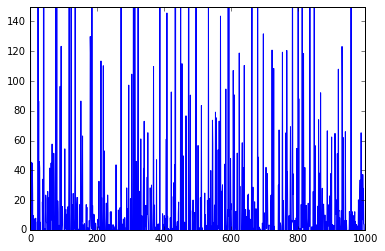

In [61]:
plt.plot(corrected_single_shot[1000:2000])
# plt.plot(flat_ave_shots[11][1000:2000])
# plt.plot(cn[1000:2000])
plt.ylim(0,150)

1.32654781689 14.2388326778


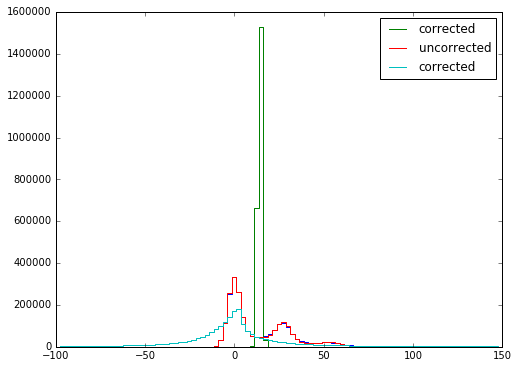

In [62]:
bins = np.linspace(-100,150,100)
# hist1=np.histogram(flat_ave_shots[14],bins=bins)
hist1=np.histogram(single_shot*universal_gain,bins=bins)
# bins = np.linspace(5,30,100)
hist2=np.histogram(cn,bins=bins)
# bins = np.linspace(-100,150,30)
hist3=np.histogram(single_shot,bins=bins)


# bins = np.linspace(-100,150,30)
hist4=np.histogram(corrected_single_shot,bins=bins)

plt.figure(figsize=[8,6])


plt.step(hist1[1][1:],hist1[0])

plt.step(hist2[1][1:],hist2[0], label='corrected')

plt.step(hist3[1][1:],hist3[0], label='uncorrected')

plt.step(hist4[1][1:],hist4[0], label='corrected')
plt.legend()
print single_shot_int, ave_bin_int[14]

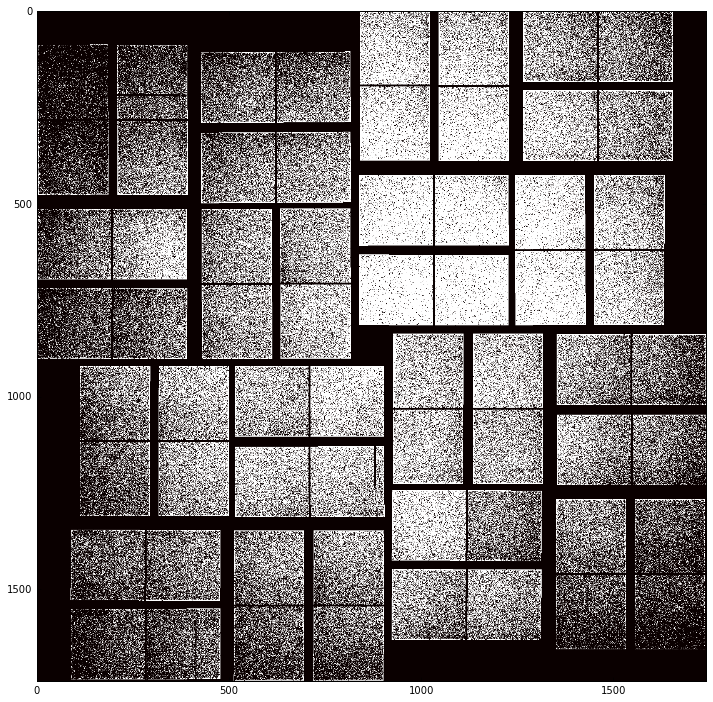

In [63]:
kk = (flat_ave_shots[14]>14)#*( single_shot<70)
plt.figure(figsize=[12,12])

plt.imshow(unflatten_shots(kk[None,:], mask)[0]*mask, aspect = 'auto'
,vmin=0,vmax = 1, cmap='hot')

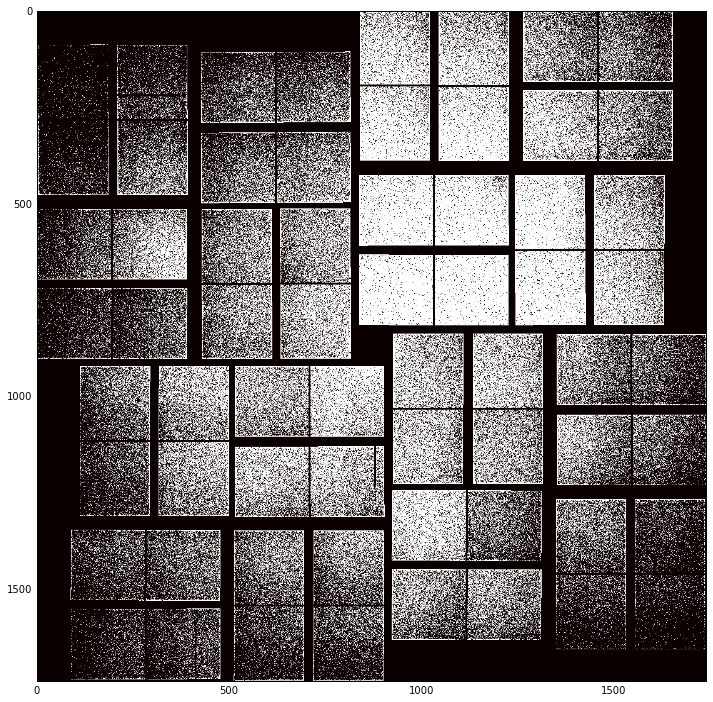

In [64]:
kk = (cn>14)#*( single_shot<70)
plt.figure(figsize=[12,12])

plt.imshow(unflatten_shots(kk[None,:], mask)[0]*mask, aspect = 'auto'
,vmin=0,vmax = 1, cmap='hot')

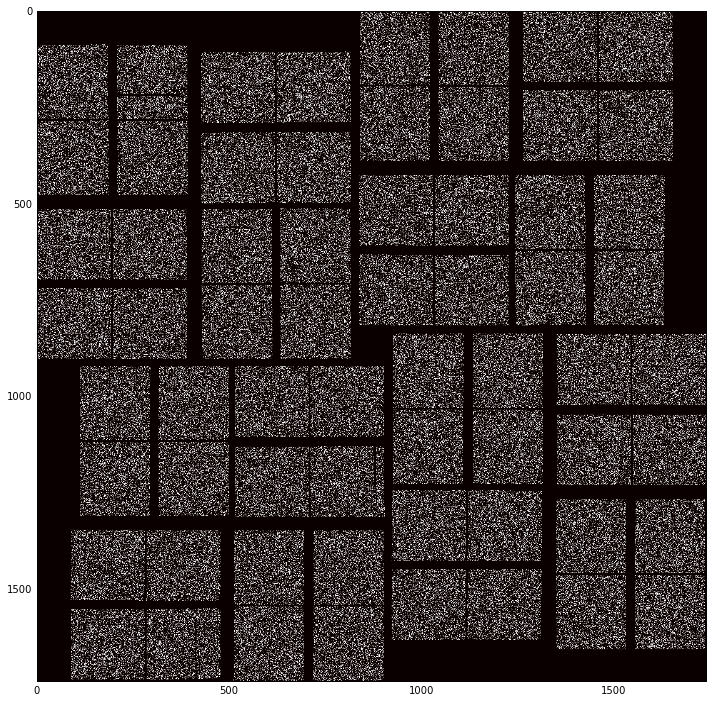

In [65]:
kk = (corrected_single_shot>14)#*( single_shot<70)
plt.figure(figsize=[12,12])

plt.imshow(unflatten_shots(kk[None,:], mask)[0]*mask, aspect = 'auto'
,vmin=0,vmax = 1, cmap='hot')

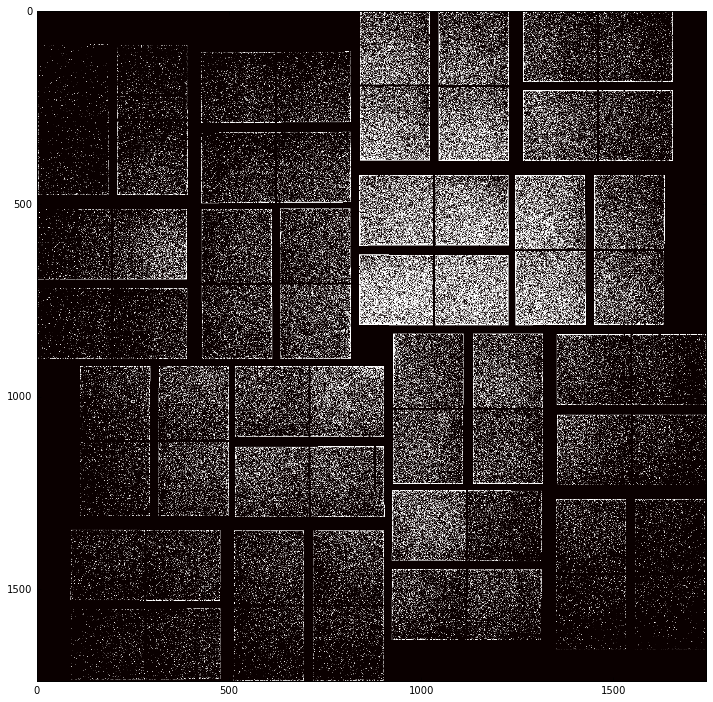

In [66]:
kk = (universal_gain<0.95)#*( single_shot<70)
plt.figure(figsize=[12,12])

plt.imshow(unflatten_shots(kk[None,:], mask)[0]*mask, aspect = 'auto'
,vmin=0,vmax = 1, cmap='hot')